## **DIGITAL SIGNAL AND IMAGE MANAGEMENT** - Davide Croatto, Hubert Nowak, Eleonora Zullo


## **Task 1** - Mono-dimensional signal processing

## Import libraries and data

Import all the libraries used in the code.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow
import matplotlib.pyplot as plt
import os
import librosa
import pickle
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cv2

In [3]:
!pip install noisereduce
import noisereduce as nr

In [4]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Conv1D,MaxPooling1D,Bidirectional
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder

In [5]:
 !pip install resampy
 from librosa.feature import mfcc
 import resampy
 import soundfile
from soundfile import LibsndfileError

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.8 MB/s eta 0:00:00


In [6]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Digital Signals/Audio_Speech_Actors_01-24.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Digital Signals/data')

## Audio exploration

We analyse our data, specifically we verify if we can apply noise reduction to the audios.

In [ ]:
test_audio,test_sample = librosa.load("/content/drive/MyDrive/Digital Signals/data/Actor_01/03-01-01-01-01-01-01.wav")
print(f'Audio Data: {test_audio[:10]}')
print(f'Sample Rate: {test_sample}')

Audio Data: [ 5.3765323e-08 -2.1233109e-08 -6.0478840e-09  3.8985974e-08
 -7.6543159e-08  1.1907764e-07 -1.6708483e-07  2.2135779e-07
 -2.8319059e-07  3.5470674e-07]
Sample Rate: 22050


In [ ]:
from IPython.display import Audio
Audio("/content/drive/MyDrive/Digital Signals/data/Actor_01/03-01-01-01-01-01-01.wav")

In [ ]:
reduced_noise_audio = nr.reduce_noise(y=test_audio, sr=test_sample)
Audio(reduced_noise_audio, rate=test_sample)

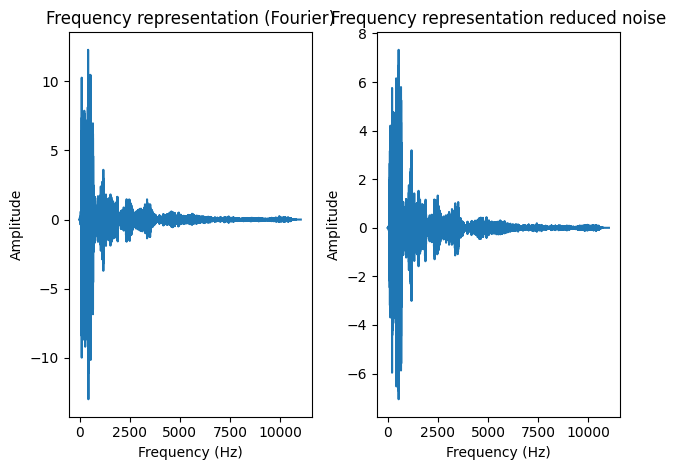

In [ ]:
sound_rfft = rfft(test_audio)
sound_rfreqs = rfftfreq(len(test_audio), 1.0/test_sample)
sound_rfft2 = rfft(reduced_noise_audio)
sound_rfreqs2 = rfftfreq(len(reduced_noise_audio), 1.0/test_sample)

plt.subplot(1, 2, 1)
plt.plot(sound_rfreqs, np.real(sound_rfft));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation (Fourier)')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.plot(sound_rfreqs2, np.imag(sound_rfft2));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation reduced noise')
plt.tight_layout()
plt.show()

The noise reduction function attenuates some high frequencies, but after that, the plots remain almost the same in terms of emotional recognition tasks. In this case, the high-frequency noise could actually be useful. We can hear in the audio that after noise reduction, the sound becomes more robotic because the higher frequencies have been removed.

For this reason, we decide to do not reduce the noise.

## MFCC representation

In [ ]:
mfccs = mfcc(y= test_audio*1.0, sr=test_sample)

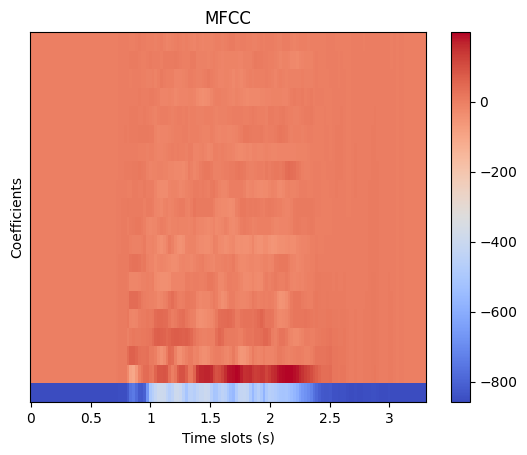

In [ ]:
specshow(mfccs, sr=test_sample, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

For deep learning algorithms that rely on gradient descent, large differences in feature scales can lead to slower convergence or even failure to converge. For this reason, we decide **to normalize** it, basing on the fact that one row represents one feture.

In general:

- Low-frequency components (low-index MFCCs) often carry significant information about the timbre or tone of the voice.
- High-frequency components (higher-index MFCCs) might reflect harshness or sharpness in speech

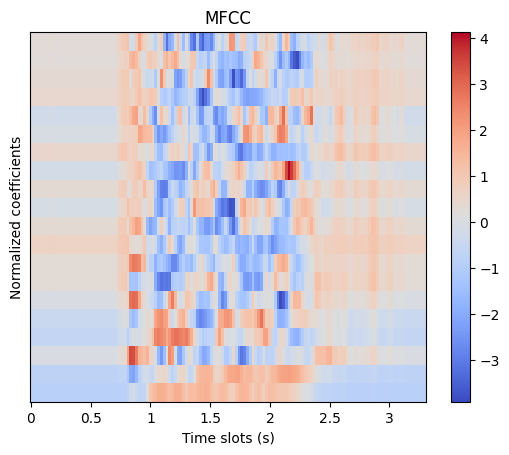

In [ ]:
# Normalize each MFCC coefficient using Z-score normalization (standardization)
scaler = StandardScaler()
mfccs_normalized = scaler.fit_transform(mfccs.T).T
specshow(mfccs_normalized, sr=test_sample, x_axis='time')

plt.xlabel('Time slots (s)')
plt.ylabel('Normalized coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

In [ ]:
mean_mfccs = np.mean(mfccs, axis=1)
std_mfccs = np.std(mfccs, axis=1)

print("Mean of MFCCs:", mean_mfccs)
print("Standard Deviation of MFCCs:", std_mfccs)

Mean of MFCCs: [-6.9779260e+02  5.4890041e+01  6.6346657e-01  1.2435784e+01
  7.7339525e+00  5.3074980e-01 -3.2166309e+00 -3.1593955e+00
 -1.0977551e+01 -2.8487113e+00  8.1529772e-01 -3.0370667e+00
  1.9554471e+00 -3.7356687e+00  4.3770060e-01  7.8235632e-01
 -4.0714293e+00 -1.8607763e+00 -1.3236899e+00 -9.2046332e-01]
Standard Deviation of MFCCs: [183.03044    72.16848    19.195799   20.930756   17.339312   13.761339
  10.853389   11.505455   17.019815    8.8651      8.669749    9.678136
   9.780213    7.676487    6.668201    3.212476    9.426749    5.3808117
   6.210259    3.4917197]


For this reason, we create a function to generate an image representation of the MFCC for each audio sample in our dataset. This transformation allows us to visualize and store the spectral characteristics of the audio, which can later be used for classification tasks.

In [7]:
# Add noise to avoid overfitting
def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio)) * noise_level
    return audio + noise

# Function to extract MFCCs and transform them into 2D images compatible with EfficientNet.
def extract_mfcc_image(file_path, target_size=(300, 300)):
    try:
        # Load the audio
        audio, sample_rate = librosa.load(file_path, duration=2.75, sr=44100, offset=0.5)
        audio_noise = add_noise(audio)

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio_noise, sr=sample_rate, n_mfcc=40)  # Più feature
        scaler = StandardScaler()
        mfcc_normalized = scaler.fit_transform(mfccs.T).T

        # Convert MFCC to image (resized for EfficientNet)
        mfcc_resized = cv2.resize(mfcc_normalized, target_size)  # Resize to (300,300)

        # Convert to 3 channels for EfficientNet (replicating across 3 channels)
        mfcc_image = np.stack([mfcc_resized] * 3, axis=-1)  # Final shape: (300,300,3)

        return mfcc_image
    except Exception as e:
        print(f"Errore nel file {file_path}: {e}")
        return None

We verify that the function worked by applying it to a single audio sample.

In [ ]:
x = extract_mfcc_image("/content/drive/MyDrive/Digital Signals/data/Actor_01/03-01-01-01-01-01-01.wav")
print(x)
x.shape

[[[-2.29488119 -2.29488119 -2.29488119]
  [-1.31888348 -1.31888348 -1.31888348]
  [-0.82511883 -0.82511883 -0.82511883]
  ...
  [-0.48291693 -0.48291693 -0.48291693]
  [-0.59730199 -0.59730199 -0.59730199]
  [-0.86373068 -0.86373068 -0.86373068]]

 [[-2.29488119 -2.29488119 -2.29488119]
  [-1.31888348 -1.31888348 -1.31888348]
  [-0.82511883 -0.82511883 -0.82511883]
  ...
  [-0.48291693 -0.48291693 -0.48291693]
  [-0.59730199 -0.59730199 -0.59730199]
  [-0.86373068 -0.86373068 -0.86373068]]

 [[-2.29488119 -2.29488119 -2.29488119]
  [-1.31888348 -1.31888348 -1.31888348]
  [-0.82511883 -0.82511883 -0.82511883]
  ...
  [-0.48291693 -0.48291693 -0.48291693]
  [-0.59730199 -0.59730199 -0.59730199]
  [-0.86373068 -0.86373068 -0.86373068]]

 ...

 [[-1.16794592 -1.16794592 -1.16794592]
  [-0.02706067 -0.02706067 -0.02706067]
  [ 0.3984573   0.3984573   0.3984573 ]
  ...
  [ 0.09870606  0.09870606  0.09870606]
  [-0.31884621 -0.31884621 -0.31884621]
  [-0.25161032 -0.25161032 -0.25161032]]

 [

(300, 300, 3)

In [ ]:
type(x)

numpy.ndarray

## Data loader

Finally, we create a function for data upload so that all audio files are processed using the newly created MFCC representation function.

In [8]:
def load_data(data_folder='/content/drive/MyDrive/Digital Signals/data'):
    data = []
    labels = []
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            # Check if the file is a WAV file
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                try:
                    emotion = file.split("-")[2]
                    if emotion:  # Ensure that emotion is not empty
                        labels.append(emotion)
                        data.append(file_path)
                    else:
                        print(f"Skipping file with invalid label: {file}")
                except IndexError:
                    print(f"Skipping file with invalid filename format: {file}")

    return data, labels

In [ ]:
link,labels = load_data()

In [ ]:
df = pd.DataFrame({'link':link,'labels':labels })
map ={
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}
df = df.replace({'labels':map})
df.head()

,link,labels
0,/content/drive/MyDrive/Digital Signals/data/Ac...,neutral
1,/content/drive/MyDrive/Digital Signals/data/Ac...,neutral
2,/content/drive/MyDrive/Digital Signals/data/Ac...,neutral
3,/content/drive/MyDrive/Digital Signals/data/Ac...,neutral
4,/content/drive/MyDrive/Digital Signals/data/Ac...,calm


In [ ]:
df = df.dropna()

In [ ]:
df['link'] = df['link'].apply(extract_mfcc_image)

<ipython-input-8-4cf68f10008f>:10: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, duration=2.75, sr=44100, offset=0.5)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Errore nel file /content/drive/MyDrive/Digital Signals/data/Actor_13/03-01-07-02-02-02-13.wav: 


In [ ]:
df['link'][0]

array([[[-2.55718011, -2.55718011, -2.55718011],
        [-1.2488792 , -1.2488792 , -1.2488792 ],
        [-0.73727747, -0.73727747, -0.73727747],
        ...,
        [-0.55772992, -0.55772992, -0.55772992],
        [-0.56950933, -0.56950933, -0.56950933],
        [-0.63411548, -0.63411548, -0.63411548]],

       [[-2.55718011, -2.55718011, -2.55718011],
        [-1.2488792 , -1.2488792 , -1.2488792 ],
        [-0.73727747, -0.73727747, -0.73727747],
        ...,
        [-0.55772992, -0.55772992, -0.55772992],
        [-0.56950933, -0.56950933, -0.56950933],
        [-0.63411548, -0.63411548, -0.63411548]],

       [[-2.55718011, -2.55718011, -2.55718011],
        [-1.2488792 , -1.2488792 , -1.2488792 ],
        [-0.73727747, -0.73727747, -0.73727747],
        ...,
        [-0.55772992, -0.55772992, -0.55772992],
        [-0.56950933, -0.56950933, -0.56950933],
        [-0.63411548, -0.63411548, -0.63411548]],

       ...,

       [[-2.14646786, -2.14646786, -2.14646786],
        [-2

In [ ]:
df['link'][0].shape

(300, 300, 3)

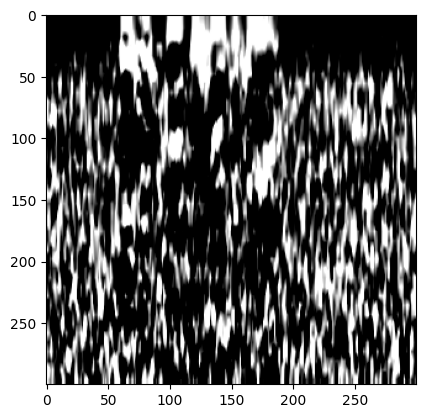

In [ ]:
plt.imshow(df['link'][0]) # Update to access the 'link' column

We save the new data.

In [ ]:
df.to_pickle('/content/drive/MyDrive/Digital Signals/dataok.pkl')

## Classification for 8 classes

We import the data created before.

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Digital Signals/dataok.pkl')

In [ ]:
df.head()

,link,labels
0,"[[[-2.704380582784426, -2.704380582784426, -2....",neutral
1,"[[[-2.7573077688810477, -2.7573077688810477, -...",neutral
2,"[[[-2.6198150656313848, -2.6198150656313848, -...",neutral
3,"[[[-2.487285843576738, -2.487285843576738, -2....",neutral
4,"[[[-3.2602263751010487, -3.2602263751010487, -...",calm


In [ ]:
df.size

2880

In [ ]:
label_counts = df['labels'].value_counts()
print(label_counts)

labels
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64


In [ ]:
map ={
    'neutral':0,
    'calm':1,
    'happy':2,
    'sad':3,
    'angry':4,
    'fearful':5,
    'disgust':6,
    'surprised':7
}
df = df.replace({'labels':map})
df.head()
df = df.dropna()

<ipython-input-9-661047f04696>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'labels':map})


In [ ]:
df.head()

,link,labels
0,"[[[-2.704380582784426, -2.704380582784426, -2....",0
1,"[[[-2.7573077688810477, -2.7573077688810477, -...",0
2,"[[[-2.6198150656313848, -2.6198150656313848, -...",0
3,"[[[-2.487285843576738, -2.487285843576738, -2....",0
4,"[[[-3.2602263751010487, -3.2602263751010487, -...",1


We weight the different categories, according to their frequency, to avoid class imbalance.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weights = compute_class_weight('balanced', classes =np.array([0,1,2,3,4,5,6,7]), y=df['labels'])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weight_dict)

Class weights: {0: 1.8736979166666667, 1: 0.9368489583333334, 2: 0.9368489583333334, 3: 0.9368489583333334, 4: 0.9368489583333334, 5: 0.9368489583333334, 6: 0.9417539267015707, 7: 0.9368489583333334}


We create the train and the test dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['link'], df['labels'], test_size=0.2, random_state=42)

We define the model architecture.

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import EfficientNetB3

base_model = EfficientNetB3(input_shape=(300, 300, 3), include_top=False, weights='imagenet')

base_model.trainable = False

inputs = keras.Input(shape=(300, 300, 3))

x = inputs
x = base_model(x, training=False)

x = keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 10, 10, 128)         │       1,769,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,703,287 (48.46 MB)

 Trainable params: 1,918,984 (7.32 MB)

 Non-trainable params: 10,784,303 (41.14 MB)

In [ ]:
# transform the x train and the x test into arrays (correct input for the model)
X_train_np = np.array(X_train.tolist())
X_test_np = np.array(X_test.tolist())

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history = model.fit(X_train_np, y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(X_test_np, y_test),
                    callbacks=[lr_reducer, early_stopping],
                    class_weight=class_weight_dict
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.2052 - loss: 2.5535 - val_accuracy: 0.0729 - val_loss: 2.2689 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 345ms/step - accuracy: 0.3282 - loss: 1.9005 - val_accuracy: 0.0729 - val_loss: 2.3020 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.3462 - loss: 1.8240 - val_accuracy: 0.0729 - val_loss: 2.2860 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.3789 - loss: 1.7682 - val_accuracy: 0.0764 - val_loss: 2.2478 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.3847 - loss: 1.6208 - val_accuracy: 0.1111 - val_loss: 2.1032 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - accuracy: 0.4307 - loss: 1.5823 - val_accuracy: 0.1389 - val_loss: 2.0471 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step -

We evaluate the model.

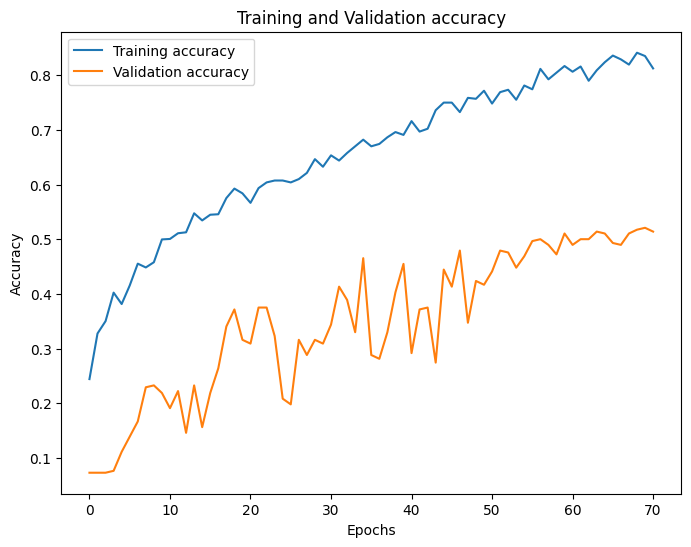

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_np, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5025 - loss: 1.4886
Test accuracy: 0.49


We save the model just created and trained.

In [ ]:
model.save('/content/drive/MyDrive/Digital Signals/model_8classes.keras')

## Classification for 3 classes

We import the data created before.

In [9]:
df2 = pd.read_pickle('/content/drive/MyDrive/Digital Signals/dataok.pkl')

In [ ]:
df2.head()

,link,labels
0,"[[[-2.704380582784426, -2.704380582784426, -2....",neutral
1,"[[[-2.7573077688810477, -2.7573077688810477, -...",neutral
2,"[[[-2.6198150656313848, -2.6198150656313848, -...",neutral
3,"[[[-2.487285843576738, -2.487285843576738, -2....",neutral
4,"[[[-3.2602263751010487, -3.2602263751010487, -...",calm


In [10]:
df2.size

2880

In [11]:
label_counts = df2['labels'].value_counts()
print(label_counts)

labels
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64


In [12]:
# new labels: we split the dataset into 3 categories now, aggregating similar categories
map ={
    'neutral':0,
    'calm':0,
    'happy':1,
    'sad':2,
    'angry':2,
    'fearful':2,
    'disgust':2,
    'surprised':1
}
df2 = df2.replace({'labels':map})
df2 = df2.dropna()

<ipython-input-12-f3f59eb27ea7>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2 = df2.replace({'labels':map})


In [ ]:
df2.head()

,link,labels
0,"[[[-2.704380582784426, -2.704380582784426, -2....",0
1,"[[[-2.7573077688810477, -2.7573077688810477, -...",0
2,"[[[-2.6198150656313848, -2.6198150656313848, -...",0
3,"[[[-2.487285843576738, -2.487285843576738, -2....",0
4,"[[[-3.2602263751010487, -3.2602263751010487, -...",0


We weight the different categories, according to their frequency, to avoid class imbalance.

In [13]:
from sklearn.utils.class_weight import compute_class_weight

In [14]:
class_weights = compute_class_weight('balanced', classes =np.array([0,1,2]), y=df2['labels'])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weight_dict)

Class weights: {0: 1.6655092592592593, 1: 1.2491319444444444, 2: 0.625380269448066}


We create the train and the test dataset.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df2['link'], df2['labels'], test_size=0.2, random_state=42)

We define the model architecture.

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import EfficientNetB3

base_model = EfficientNetB3(input_shape=(300, 300, 3), include_top=False, weights='imagenet')

base_model.trainable = False

inputs = keras.Input(shape=(300, 300, 3))

x = inputs
x = base_model(x, training=False)

x = keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 300, 300, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 128)         │       1,769,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,702,642 (48.46 MB)

 Trainable params: 1,918,339 (7.32 MB)

 Non-trainable params: 10,784,303 (41.14 MB)

In [ ]:
# transform the x train and the x test into arrays (correct input for the model)
X_train_np = np.array(X_train.tolist())
X_test_np = np.array(X_test.tolist())

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=3, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history = model.fit(X_train_np, y_train,
                    batch_size=64,
                    epochs=100,
                    validation_data=(X_test_np, y_test),
                    callbacks=[lr_reducer, early_stopping],
                    class_weight=class_weight_dict
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.4242 - loss: 1.3453 - val_accuracy: 0.3056 - val_loss: 1.1237 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 338ms/step - accuracy: 0.5545 - loss: 0.8784 - val_accuracy: 0.4410 - val_loss: 1.0965 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.5460 - loss: 0.8670 - val_accuracy: 0.4236 - val_loss: 1.0663 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.5532 - loss: 0.8777 - val_accuracy: 0.6285 - val_loss: 0.9558 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.5798 - loss: 0.8611 - val_accuracy: 0.3368 - val_loss: 1.0336 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.5948 - loss: 0.8727 - val_accuracy: 0.6042 - val_loss: 0.9709 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - 

We evaluate the model.

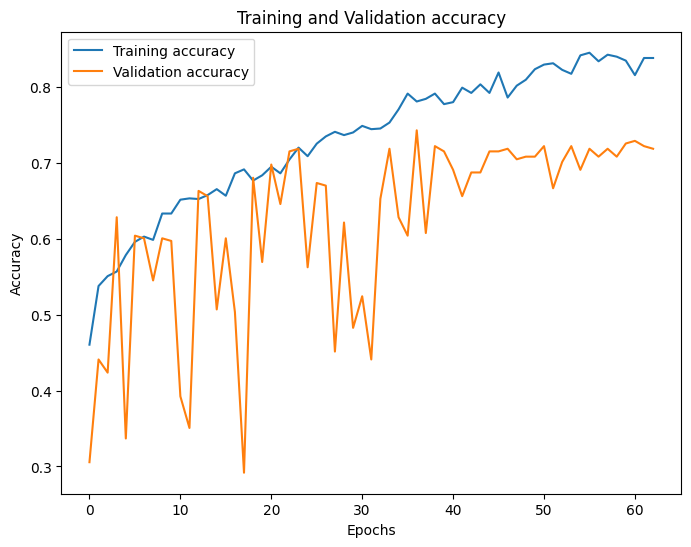

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_np, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.7138 - loss: 0.7089
Test accuracy: 0.72


We save the model just created and trained.

In [ ]:
model.save('/content/drive/MyDrive/Digital Signals/model_3classes.keras')

# TEST

In [ ]:
happy = extract_mfcc_image("/content/drive/MyDrive/Digital Signals/Happy.m4a")
sad = extract_mfcc_image("/content/drive/MyDrive/Digital Signals/Sad.m4aSad.m4a")
audio = extract_mfcc_image("/content/drive/MyDrive/Digital Signals/03-01-08-01-01-02-03.wav")

Using the classification model for 8 classes.

In [18]:
model_8classes = keras.models.load_model('/content/drive/MyDrive/Digital Signals/model_8classes.keras')

In [ ]:
# from the test set
sample = np.expand_dims(X_test[1086], axis=0)

y_pred = model_8classes.predict(sample)
print("Predicted:", y_pred, "True:", y_test[1086])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted: [[0.41586757 0.19199464 0.02740732 0.16611539 0.01306657 0.09826119
  0.02536529 0.06192202]] True: 0


In [ ]:
# out of test set
sample = np.expand_dims(sad, axis=0)

y_pred = model_8classes.predict(sample)
print("Predicted:", y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Predicted: [[0.00286296 0.02712166 0.00712081 0.03100646 0.18828458 0.08499151
  0.64723593 0.01137614]]


Using the classification model for 3 classes

In [19]:
model_3classes = keras.models.load_model('/content/drive/MyDrive/Digital Signals/model_3classes.keras')

In [ ]:
# from the test set
sample = np.expand_dims(X_test[1086], axis=0)

y_pred = model_3classes.predict(sample)
print("Predicted:", y_pred, "True:", y_test[1086])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: [[0.8587674  0.03437255 0.10686003]] True: 0


In [ ]:
# out of test set
sample = np.expand_dims(sad, axis=0)

y_pred = model_3classes.predict(sample)
print("Predicted:", y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted: [[0.06674766 0.02399135 0.909261  ]]


With an external audio of the initial dataset.

Using the classification model for 8 classes



In [22]:
# out of test set
sample = np.expand_dims(audio, axis=0)

y_pred = model_8classes.predict(sample)
print("Predicted:", y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: [[4.0202573e-04 6.8469235e-04 2.1928133e-02 3.5407681e-02 1.1758447e-02
  5.2353845e-04 7.6923176e-04 9.2852616e-01]]


Using the classification model for 3 classes

In [23]:
# out of test set
sample = np.expand_dims(audio, axis=0)

y_pred = model_3classes.predict(sample)
print("Predicted:", y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: [[0.00636744 0.963346   0.03028656]]
